In [1]:
import kagglehub

path = kagglehub.competition_download("2025-sep-dl-gen-ai-project")
print("Local competition path:", path)


Local competition path: C:\Users\Gurur\.cache\kagglehub\competitions\2025-sep-dl-gen-ai-project


In [40]:
import os

os.chdir(r"C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project")
print("Now CWD =", os.getcwd())


Now CWD = C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project


In [2]:
import os
import pandas as pd
import kagglehub

COMP_SLUG = "2025-sep-dl-gen-ai-project"

def get_competition_dir(slug=COMP_SLUG):
    kaggle_input_root = f"/kaggle/input/{slug}"
    if os.path.exists(kaggle_input_root):
        print("Detected Kaggle environment, using:", kaggle_input_root)
        return kaggle_input_root

    print("Running locally, downloading via Kaggle Hub...")
    comp_dir = kagglehub.competition_download(slug)
    print("Local competition dir:", comp_dir)
    return comp_dir

comp_dir = get_competition_dir()

train = pd.read_csv(os.path.join(comp_dir, "train.csv"))
test = pd.read_csv(os.path.join(comp_dir, "test.csv"))
sample_submission = pd.read_csv(os.path.join(comp_dir, "sample_submission.csv"))

print(train.shape, test.shape, sample_submission.shape)


Running locally, downloading via Kaggle Hub...
Local competition dir: C:\Users\Gurur\.cache\kagglehub\competitions\2025-sep-dl-gen-ai-project
(6827, 8) (1707, 2) (1707, 6)


In [3]:
import wandb

wandb.login()

wandb: Currently logged in as: 22f3000400 (DL-Genai-Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
WANDB_ENTITY = "DL-Genai-Project"       
WANDB_PROJECT = "22f3000400-t32025"    

run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    name="smoketest-no-model",
    config={"purpose": "env_check"}
)

wandb.log({"dummy_metric": 1.0})

run.finish()


dummy_metric,▁
dummy_metric,1


In [5]:
# train = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/train.csv")
# test = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/test.csv")
# sample_sub = pd.read_csv("/kaggle/input/2025-sep-dl-gen-ai-project/sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (6827, 8)
Test shape: (1707, 2)


,id,text,anger,fear,joy,sadness,surprise,emotions
0,0,the dentist that did the work apparently did a...,1,0,0,1,0,['anger' 'sadness']
1,1,i'm gonna absolutely ~~suck~~ be terrible duri...,0,1,0,1,0,['fear' 'sadness']
2,2,"bridge: so leave me drowning calling houston, ...",0,1,0,1,0,['fear' 'sadness']
3,3,after that mess i went to see my now ex-girlfr...,1,1,0,1,0,['anger' 'fear' 'sadness']
4,4,"as he stumbled i ran off, afraid it might some...",0,1,0,0,0,['fear']


In [6]:
label_cols = ["anger", "fear", "joy", "sadness", "surprise"]

# Data Cleaning and EDA

In [7]:
print(train.isnull().sum())

id          0
text        0
anger       0
fear        0
joy         0
sadness     0
surprise    0
emotions    0
dtype: int64


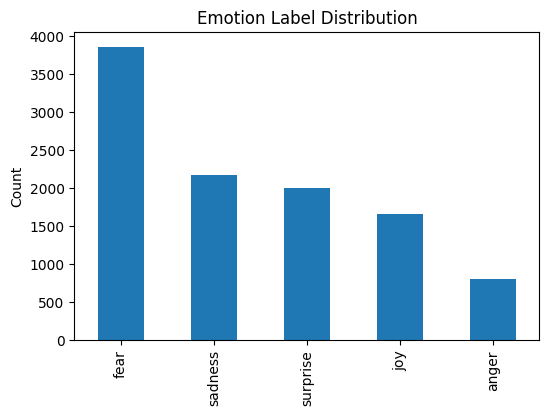

In [8]:
#Label distribution
import matplotlib.pyplot as plt
import seaborn as sns
train[label_cols].sum().sort_values(ascending=False).plot(kind='bar', figsize=(6,4))
plt.title("Emotion Label Distribution")
plt.ylabel("Count")
plt.show()

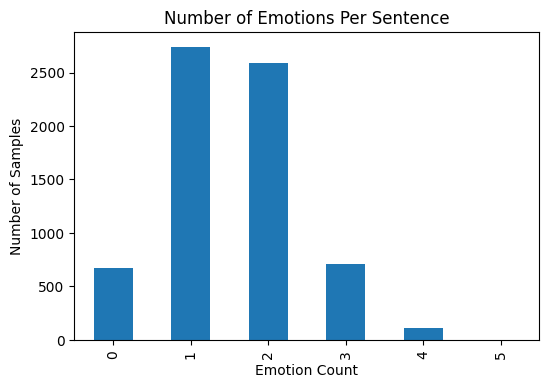

In [9]:
#Number of emotions per text
train["num_emotions"] = train[label_cols].sum(axis=1)

train["num_emotions"].value_counts().sort_index().plot(kind='bar', figsize=(6,4))
plt.title("Number of Emotions Per Sentence")
plt.xlabel("Emotion Count")
plt.ylabel("Number of Samples")
plt.show()

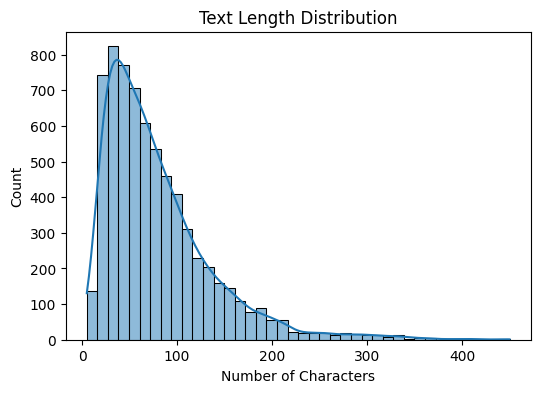

Average text length: 79.43078951223085
Max length: 450
Min length: 5


In [10]:
#Text length distribution
train["text_len"] = train["text"].astype(str).apply(len)

plt.figure(figsize=(6,4))
sns.histplot(train["text_len"], bins=40, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of Characters")
plt.show()

print("Average text length:", train["text_len"].mean())
print("Max length:", train["text_len"].max())
print("Min length:", train["text_len"].min())


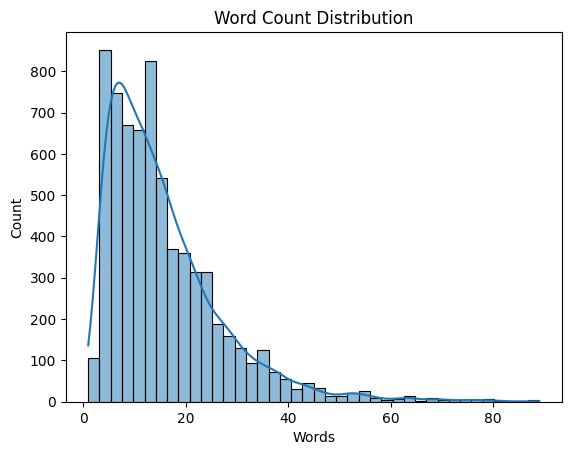

Average words: 15.684781016551927


In [11]:
#Word count distribution
train["word_count"] = train["text"].apply(lambda x: len(str(x).split()))

sns.histplot(train["word_count"], bins=40, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Words")
plt.show()

print("Average words:", train["word_count"].mean())

In [12]:
#duplicates
print("Duplicate texts:", train.duplicated("text").sum())


Duplicate texts: 1841


In [13]:
#noisy examples
noisy_examples = train[train["text"].str.contains("[^a-zA-Z0-9.,!?/' ]")]["text"].head(10)
print("Noisy text samples:\n")
for t in noisy_examples:
    print("-", t)

Noisy text samples:

- i'm gonna absolutely ~~suck~~ be terrible during my first sexual experience ._.
- bridge: so leave me drowning calling houston, and let my lungs cave in, from calling god, for my mistakes and to the one who deserves the apology.
- after that mess i went to see my now ex-girlfriend at school because she refused to drive home to see me.
- " and burst into tears.
- first me, a slight stir from my legs, a stretching of my toes, and immediately following my father says, `` hmm? ''
- the song `` poor places '' is ironically seeping out of my speakers and into my ears: it's hot in the poor places tonight / i'm not going outside
- so i was like "wtf, you have the bag, read the bag.
- `` i felt my eyelids swelling shut and the crack in my collarbone started to throb.
- i never saw that thing again, because evidently it was "stolen".
- "  i'm like "sure.


In [14]:
import re
import html

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)
    text = text.encode("ascii", "ignore").decode()
    text = re.sub(r"\s+", " ", text).strip()
    return text
    
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)

In [15]:
# # Basic cleaning 
train['text'] = train['text'].astype(str).fillna("")
test['text'] = test['text'].astype(str).fillna("")

In [16]:
# #Utilise the TfidfVectorizer to tokenize the text feature dataset, setting the following parameters: ngram_range=(1, 2) and stop_words=‘english’.
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = vectorizer.fit_transform(train['text'])

# Insights on Data

In [17]:
# #What is the dimension of your feature matrix?
X.shape

(6827, 33896)

In [18]:
# #Is this feature representation sparse or dense?
from scipy import sparse
print(sparse.issparse(X))

True


In [19]:
# #Which emotion is the most common in the given dataset?
emotion = train[label_cols].sum().sort_values(ascending=False)

print("\nMost common emotion:", emotion.idxmax())
print("Count:", emotion.max())


Most common emotion: fear
Count: 3860


In [20]:
# #What is the total count of such instances in the training set that have exactly 2 labels?
train["label_sum"] = train[label_cols].sum(axis=1)
labels = (train["label_sum"] == 2).sum()

print("\nRows with exactly 2 labels:", labels)


Rows with exactly 2 labels: 2587


In [21]:
# #What is the number of rows where 'Joy' and 'Sadness' occur together in the training set?
row = ((train["joy"] == 1) & (train["sadness"] == 1)).sum()

print("\nJoy & Sadness:", row)


Joy & Sadness: 96


In [22]:
# #What is the percentage of the dataset containing 'Surprise'?
surprise = 100 * (train["surprise"].sum() / len(train))

print(f"Percentage: {surprise:.2f}%")

Percentage: 29.28%


In [23]:
# #What is the maximum difference in occurrence counts between any two emotion labels?
diff = emotion.max() - emotion.min()

print("\nMaximum difference:", diff)


Maximum difference: 3052


In [24]:
# #What is the median word length of the texts?
train["word_count"] = train["text"].astype(str).apply(lambda x: len(x.split()))
median = train["word_count"].median()

print("\nMedian:", median)


Median: 13.0


In [25]:
# #What is the correlation coefficient value between anger and fear? Round to 2 decimal places.
corr = round(train["anger"].corr(train["fear"]), 2)

print("\nCorrelation:", corr)


Correlation: 0.08


In [26]:
# #Convert all text to lowercase for normalization. Remove all special characters from the dataset using string.punctuation
import string
train["text_clean"] = train["text"].astype(str).str.lower()

def remove(text):
    return text.translate(str.maketrans("", "", string.punctuation))

train["text_clean"] = train["text_clean"].apply(remove)

In [27]:
# #What is the percentage reduction in total character count after removing punctuation?
original = train["text"].astype(str).apply(len).sum()
clean = train["text_clean"].astype(str).apply(len).sum()
reduction = 100 * (original - clean) / original

print(f"\nPercentage reduction: {reduction:.2f}%")



Percentage reduction: 3.26%


In [28]:
# # Basic cleaning 
train['text'] = train['text'].astype(str).fillna("")
test['text'] = test['text'].astype(str).fillna("")

# Model Training

In [46]:
from sklearn.model_selection import train_test_split
import numpy as np

label_cols = ["anger", "fear", "joy", "sadness", "surprise"]

# Use cleaned text if available, otherwise raw text
TEXT_COL = "clean_text" if "clean_text" in train.columns else "text"
print("Using text column:", TEXT_COL)

# Make sure labels are float32
for col in label_cols:
    train[col] = train[col].astype("float32")

train_df, val_df = train_test_split(
    train,
    test_size=0.1,
    random_state=42,
    stratify=train[label_cols].values.argmax(axis=1),  # rough stratification
)

print("Train size:", train_df.shape[0], "Val size:", val_df.shape[0])

train_texts = train_df[TEXT_COL].astype(str).tolist()
val_texts = val_df[TEXT_COL].astype(str).tolist()
test_texts = test[TEXT_COL if TEXT_COL in test.columns else "text"].astype(str).tolist()

y_train = train_df[label_cols].values.astype("float32")
y_val = val_df[label_cols].values.astype("float32")

print("y_train shape:", y_train.shape, "y_val shape:", y_val.shape)


Using text column: clean_text
Train size: 6144 Val size: 683
y_train shape: (6144, 5) y_val shape: (683, 5)


In [47]:
from collections import Counter

MAX_VOCAB_SIZE = 20000
MAX_LEN = 80   # keep it modest for CPU training

counter = Counter()
for text in train_texts:
    counter.update(text.split())

most_common = counter.most_common(MAX_VOCAB_SIZE - 2)

stoi = {"<pad>": 0, "<unk>": 1}
for idx, (word, _) in enumerate(most_common, start=2):
    stoi[word] = idx

vocab_size = len(stoi)
print("Vocab size:", vocab_size)

def encode_text(text, stoi_dict, max_len):
    tokens = text.split()
    ids = [stoi_dict.get(tok, 1) for tok in tokens][:max_len]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    return ids

X_train_ids = np.array([encode_text(t, stoi, MAX_LEN) for t in train_texts], dtype="int64")
X_val_ids = np.array([encode_text(t, stoi, MAX_LEN) for t in val_texts], dtype="int64")
X_test_ids = np.array([encode_text(t, stoi, MAX_LEN) for t in test_texts], dtype="int64")

print("Train IDs:", X_train_ids.shape, "Val IDs:", X_val_ids.shape, "Test IDs:", X_test_ids.shape)


Vocab size: 11181
Train IDs: (6144, 80) Val IDs: (683, 80) Test IDs: (1707, 80)


In [48]:
import torch
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

class LSTMDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = None
        if y is not None:
            self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64

train_dataset_lstm = LSTMDataset(X_train_ids, y_train)
val_dataset_lstm = LSTMDataset(X_val_ids, y_val)
test_dataset_lstm = LSTMDataset(X_test_ids, None)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=BATCH_SIZE, shuffle=False)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader_lstm), len(val_loader_lstm), len(test_loader_lstm)


Device: cpu


(96, 11, 27)

In [49]:
from torch import nn

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        h_cat = torch.cat((h_forward, h_backward), dim=1)
        x = self.dropout(h_cat)
        logits = self.fc(x)
        return logits

EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_LABELS = len(label_cols)

model1 = BiLSTMModel(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_LABELS).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

model1


BiLSTMModel(
  (embedding): Embedding(11181, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [50]:
from sklearn.metrics import f1_score, accuracy_score

def evaluate_lstm(model, dataloader, device, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    return macro_f1, acc


In [51]:
EPOCHS = 10 

run = wandb.init(
    entity=WANDB_ENTITY,
    project=WANDB_PROJECT,
    name="model1_bilstm_scratch",
    config={
        "model": "BiLSTM_scratch",
        "max_vocab_size": MAX_VOCAB_SIZE,
        "max_len": MAX_LEN,
        "embed_dim": EMBED_DIM,
        "hidden_dim": HIDDEN_DIM,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "lr": 1e-3,
    },
)

best_val_f1 = 0.0
best_state_dict = None

for epoch in range(EPOCHS):
    model1.train()
    running_loss = 0.0

    for inputs, labels in train_loader_lstm:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model1(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader_lstm.dataset)
    val_f1, val_acc = evaluate_lstm(model1, val_loader_lstm, DEVICE)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state_dict = model1.state_dict()

    wandb.log(
        {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_macro_f1": val_f1,
            "val_accuracy": val_acc,
        }
    )

    print(
        f"Epoch {epoch + 1}/{EPOCHS} - loss: {train_loss:.4f} - val_f1: {val_f1:.4f} - val_acc: {val_acc:.4f}"
    )

if best_state_dict is not None:
    model1.load_state_dict(best_state_dict)

print("Best validation macro F1:", best_val_f1)

run.finish()


Epoch 1/10 - loss: 0.5747 - val_f1: 0.1432 - val_acc: 0.1611
Epoch 2/10 - loss: 0.5420 - val_f1: 0.2039 - val_acc: 0.1772
Epoch 3/10 - loss: 0.5098 - val_f1: 0.3373 - val_acc: 0.2387
Epoch 4/10 - loss: 0.4533 - val_f1: 0.4214 - val_acc: 0.2899
Epoch 5/10 - loss: 0.3931 - val_f1: 0.4717 - val_acc: 0.3163
Epoch 6/10 - loss: 0.3248 - val_f1: 0.5270 - val_acc: 0.3675
Epoch 7/10 - loss: 0.2644 - val_f1: 0.5710 - val_acc: 0.4217
Epoch 8/10 - loss: 0.2138 - val_f1: 0.6013 - val_acc: 0.4612
Epoch 9/10 - loss: 0.1717 - val_f1: 0.6439 - val_acc: 0.4993
Epoch 10/10 - loss: 0.1398 - val_f1: 0.6645 - val_acc: 0.5198
Best validation macro F1: 0.6644987762790899


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▆▅▄▃▂▂▁
val_accuracy,▁▁▃▄▄▅▆▇██
val_macro_f1,▁▂▄▅▅▆▇▇██
epoch,10
train_loss,0.13976
val_accuracy,0.51977
val_macro_f1,0.6645


In [53]:
from pathlib import Path

ROOT = Path.cwd()
ARTIFACT_DIR = ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

MODEL1_PATH = ARTIFACT_DIR / "model1_bilstm_scratch.pt"
submission_path = ARTIFACT_DIR / "submission_model1_bilstm.csv"
torch.save(
    {
        "model_state_dict": model1.state_dict(),
        "stoi": stoi,
        "max_len": MAX_LEN,
        "embed_dim": EMBED_DIM,
        "hidden_dim": HIDDEN_DIM,
        "label_cols": label_cols,
        "vocab_size": vocab_size,
    },
    MODEL1_PATH,
)
print("Saved checkpoint to:", MODEL1_PATH)


Saved checkpoint to: C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project\artifacts\model1_bilstm_scratch.pt


In [54]:
model1.eval()
all_test_preds = []

with torch.no_grad():
    for inputs in test_loader_lstm:
        inputs = inputs.to(DEVICE)
        logits = model1(inputs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float().cpu().numpy()
        all_test_preds.append(preds)

all_test_preds = np.vstack(all_test_preds)

submission_model1 = pd.DataFrame(all_test_preds, columns=label_cols)
submission_model1.insert(0, "id", test["id"])

submission_model1.head() 
submission_model1.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)

Saved submission to: C:\Users\Gurur\OneDrive\Desktop\PROJECTS\2025-Sep-DLGenAI-Project\artifacts\submission_model1_bilstm.csv
